<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/delivery/2B_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependency & DeepLab

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [ ]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from google.colab import drive
import os

!git clone -b angelo --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git
!cp AML_2025_project4/utils.py .
drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 1008.28 KiB | 9.51 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Mounted at /content/drive


In [ ]:
import importlib
import utils  # Replace with the actual module name
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
import tqdm
from utils import get_loveDA

paths = get_loveDA()
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


### Load PIDNET PreTrained Weight

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)
        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []
        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []
        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out

class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y
        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)
        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)
        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

### Instantiate model

In [ ]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)
  print("imagenet-pretrained pidnet weights downloaded")

In [ ]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

class Config:
    class MODEL:
        NAME = 'pidnet_s'
        PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
    class DATASET:
        NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
next(model.parameters()).device

device(type='cpu')

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

RESIZE = (512, 512)  # Target size to resize images and masks

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        # Sorted list of image filenames to maintain consistent ordering
        self.image_filenames = sorted(os.listdir(image_dir))
        # Sorted list of mask filenames to maintain consistent ordering
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        # Return total number of samples in the dataset
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Construct full paths for image and corresponding mask
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Load the image and convert to RGB format (3 channels)
        image = Image.open(img_path).convert("RGB")
        # Load the mask and convert to grayscale (1 channel)
        mask = Image.open(mask_path).convert("L")

        # Apply image transformations (e.g., resize, tensor conversion) if provided
        if self.transform:
            image = self.transform(image)

        # Apply mask transformations (e.g., resize) if provided
        if self.target_transform:
            mask = self.target_transform(mask)

        # Convert mask to numpy array for edge detection
        mask_np = np.array(mask)

        # Apply Canny edge detection on the mask to find boundaries
        # Note: Thresholds (0.1, 0.2) may need tuning based on mask intensity range
        edge = cv2.Canny(mask_np, 0.1, 0.2)

        # Define a 3x3 kernel for dilation to thicken edges
        kernel = np.ones((3, 3), np.uint8)

        # Crop 6 pixels from each side of the edge map to avoid border effects
        edge = edge[6:-6, 6:-6]
        # Pad the cropped edge map back to original size with zeros
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')

        # Dilate the edges to make boundaries thicker and more visible
        boundaries = cv2.dilate(edge, kernel, iterations=1)
        # Convert boundaries to binary float mask: 1.0 for boundary pixels, 0.0 otherwise
        boundaries = (boundaries > 50) * 1.0

        # Convert mask to torch tensor of int64 type and subtract 1 for zero-based class indices
        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        # Convert boundaries mask to torch float tensor
        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        # Return the transformed image, the label mask, and the boundaries mask
        return image, mask, boundaries_tensor

# Define image transformations pipeline
image_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.BILINEAR),  # Resize images with bilinear interpolation
    transforms.ToTensor(),  # Convert images to PyTorch tensors (C x H x W) normalized to [0, 1]
])

# Define mask transformations pipeline
mask_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.NEAREST),  # Resize masks with nearest neighbor interpolation to preserve labels
])

# Create dataset instances for training and validation
train_dataset_urban = SegmentationDataset(
    TRAINING_PATH_URBAN + "/images_png",
    TRAINING_PATH_URBAN + "/masks_png",
    transform=image_transform,
    target_transform=mask_transform
)
val_dataset_urban = SegmentationDataset(
    VAL_PATH_URBAN + "/images_png",
    VAL_PATH_URBAN + "/masks_png",
    transform=image_transform,
    target_transform=mask_transform
)

BATCH_SIZE = 8  # Number of samples per batch

# Create DataLoader objects for training and validation datasets
# Training DataLoader shuffles data and uses multiple workers for faster loading
train_loader = DataLoader(train_dataset_urban, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# Validation DataLoader does not shuffle data
val_loader = DataLoader(val_dataset_urban, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512]) torch.Size([8, 512, 512])


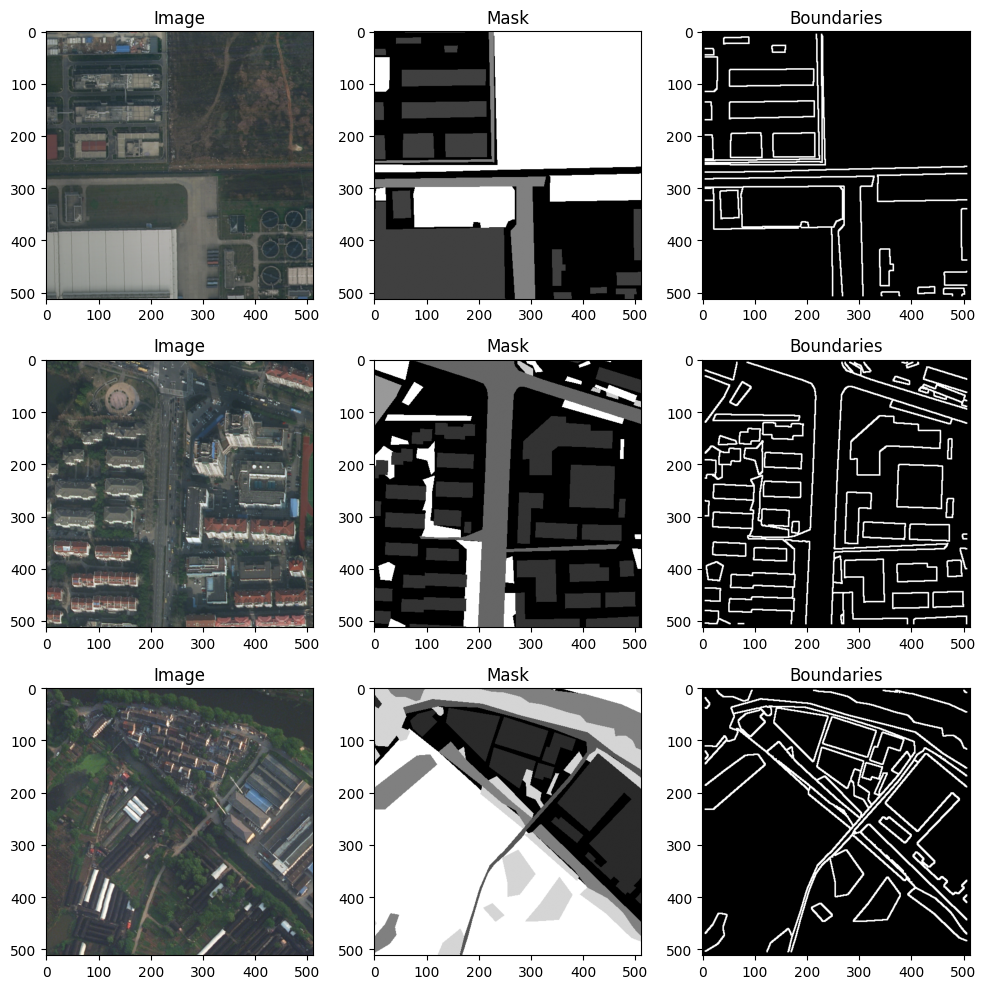

In [ ]:
from utils import show  # (Assuming you have some utility function for displaying images, not used here)
from matplotlib import pyplot as plt

# Print the shapes of images, masks, and boundaries tensors in one batch from train_loader
print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, next(iter(train_loader))[2].shape)

# Get one batch of data from the training DataLoader
batch = next(iter(train_loader))  # batch is a tuple: (images, masks, boundaries)
images, masks, boundaries = batch  # Unpack the batch tuple

# Create a 3x3 grid of subplots: 3 rows (for 3 samples), 3 columns (Image, Mask, Boundaries)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop over the first 3 samples in the batch to visualize them
for i in range(3):
    # Display the image:
    # images[i] shape is (C, H, W), permute to (H, W, C) for matplotlib's imshow
    axes[i, 0].imshow(images[i].permute(1, 2, 0))
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')  # Optional: hide axis ticks for cleaner look

    # Display the mask:
    # Convert to numpy and use grayscale colormap
    axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')

    # Display the boundaries:
    # Convert to numpy and use grayscale colormap
    axes[i, 2].imshow(boundaries[i].cpu().numpy(), cmap="gray")
    axes[i, 2].set_title("Boundaries")
    axes[i, 2].axis('off')

# Adjust layout so titles and images don't overlap
plt.tight_layout()
plt.show()

## Training Phase

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device);

cpu


## Criterions

In [ ]:
def weighted_bce(bd_pre, target):
    # Get the shape of the predicted boundary tensor: batch size (n), channels (c), height (h), width (w)
    n, c, h, w = bd_pre.size()

    # Rearrange bd_pre from (N, C, H, W) to a 2D tensor (1, N*C*H*W) flattening all spatial and channel dims
    log_p = bd_pre.permute(0, 2, 3, 1).contiguous().view(1, -1)

    # Flatten the target tensor similarly into shape (1, N*C*H*W)
    target_t = target.view(1, -1)

    # Create boolean masks for positive (boundary) and negative (non-boundary) pixels
    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    # Initialize a weights tensor with zeros, same shape as log_p
    weight = torch.zeros_like(log_p)

    # Count the number of positive and negative pixels
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num

    # Assign weights inversely proportional to the frequency of each class
    # This balances the loss so that rare classes (e.g., boundaries) are weighted more
    weight[pos_index] = neg_num * 1.0 / sum_num  # Weight for positive pixels
    weight[neg_index] = pos_num * 1.0 / sum_num  # Weight for negative pixels

    # Compute binary cross-entropy loss with logits, applying the computed weights
    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

class BondaryLoss(nn.Module):
    def __init__(self, coeff_bce=20.0):
        super(BondaryLoss, self).__init__()
        # Scaling coefficient for BCE loss to emphasize boundary loss contribution
        self.coeff_bce = coeff_bce

    def forward(self, bd_pre, bd_gt):
        # Calculate the weighted BCE loss, multiplied by the coefficient
        bce_loss = self.coeff_bce * weighted_bce(bd_pre, bd_gt)
        # Return the final boundary loss
        return bce_loss

File downloaded successfully!


In [ ]:
from criterion import

# TODO: cambiare da cross entropy a semantic loss (vedere paper)
semantic_loss = criterion.CrossEntropyLoss(ignore_label=-1)

boundary_loss = BondaryLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

from utils import train_step, validation_step

# Create directory to save model checkpoints if it doesn't exist
os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

EPOCHS = 20
torch.manual_seed(42)  # Set seed for reproducibility

# Initialize Mean Intersection over Union metric for semantic segmentation
miou = MeanIoU(num_classes=NUM_CLASSES).to(device)

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode

    # Iterate over batches from the training dataloader with progress bar
    for batch, (X, y, boundaries_gt) in enumerate(tqdm(train_loader)):

        # Move inputs and targets to the computation device (GPU/CPU)
        X = X.to(device)
        y = y.to(device)
        boundaries_gt = boundaries_gt.float().to(device)  # boundaries_gt as float for loss computation

        # Forward pass: get model predictions
        outputs = model(X)

        # Compute semantic segmentation loss on segmentation outputs (all but last output)
        loss_s = semantic_loss(outputs[:-1], y)

        # Compute boundary loss on last output (boundary prediction)
        loss_b = bd_loss(outputs[-1], boundaries_gt)

    print(f"Epoch {epoch+1}/{EPOCHS} | Training Loss: {avg_train_loss} | Validation Loss: {avg_val_loss} | mIoU: {miou_score:.4f}")

Epoch 1/20 | Training Loss: 1.6320026541578359 | Validation Loss: 1.642723511247074 | mIoU: 0.3563
Epoch 2/20 | Training Loss: 0.9471012522434367 | Validation Loss: 1.3253605204470018 | mIoU: 0.4468
Epoch 3/20 | Training Loss: 0.8490344454502238 | Validation Loss: 1.2860782300724702 | mIoU: 0.4768
Epoch 4/20 | Training Loss: 0.7961318451782753 | Validation Loss: 1.3669234850827385 | mIoU: 0.4613
Epoch 5/20 | Training Loss: 0.7411038809809192 | Validation Loss: 1.3004990142934463 | mIoU: 0.4513
Epoch 6/20 | Training Loss: 0.7120322848188466 | Validation Loss: 1.3932166387053098 | mIoU: 0.4917
Epoch 7/20 | Training Loss: 0.6869059336596521 | Validation Loss: 1.3229588585741379 | mIoU: 0.4907
Epoch 8/20 | Training Loss: 0.6636297334884775 | Validation Loss: 1.4369308717110578 | mIoU: 0.4401
Epoch 9/20 | Training Loss: 0.6336315235187268 | Validation Loss: 1.4105325390310848 | mIoU: 0.4746
Epoch 10/20 | Training Loss: 0.6078775492207757 | Validation Loss: 1.448742504680858 | mIoU: 0.4817
E

In [ ]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

*********


FLOPs: 185.015 GFLOPs
Average inference latency is 0.043 seconds.


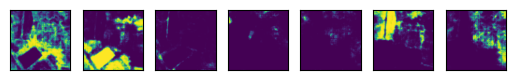

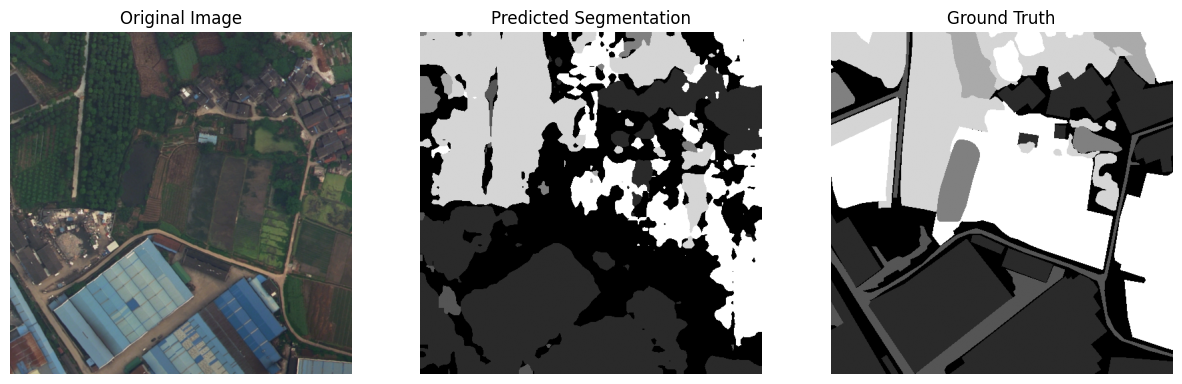

Params: 43.016 M


In [ ]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import random

from utils import show

model.eval()  # Set model to evaluation mode (disables dropout, batchnorm updates, etc.)

with torch.inference_mode():  # Disable gradient computations for inference efficiency and memory savings
    # Select a random index from the validation dataset
    random_index = random.randint(0, len(val_dataset_urban) - 1)

    # Get one sample (image and corresponding ground truth mask)
    X, y = val_dataset_urban[random_index]

    # Move image tensor to device and add batch dimension (batch size = 1)
    X = X.to(device).unsqueeze(dim=0)
    y = y.to(device)

    # Measure inference latency (time to perform a forward pass)
    start = timer()
    output = model(X)  # Forward pass through the model
    end = timer()
    latency = end - start  # Time in seconds for one inference

# Compute FLOPs (floating point operations) to estimate model complexity for this input size
flops = FlopCountAnalysis(model, X.clone())

# Apply softmax along the class dimension to convert logits to normalized probabilities
normalized_masks = torch.nn.functional.softmax(output, dim=1)

# Extract per-class probability masks from the output for visualization
# Iterate over batch size (here 1) and semantic classes to gather each class mask
masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(1)
    for cls in SEM_CLASSES
]

show(masks)  # Use your utility to display the probability masks

print("*********")

# Print model complexity and inference speed info
print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")  # Convert FLOPs to gigaFLOPs
print(f"Average inference latency is {latency:.3f} seconds.")  # Latency in seconds

# Prepare tensors for visualization by converting to numpy arrays:
out = output.squeeze().argmax(dim=0).cpu().numpy()  # Predicted segmentation mask: pick class with max prob per pixel
y_np = y.squeeze().cpu().numpy()  # Ground truth mask as numpy array
X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Original image, convert from (C,H,W) to (H,W,C) for plt.imshow()

# Create a figure with 3 side-by-side images:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show original image
axes[0].imshow(X_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show predicted segmentation
axes[1].imshow(out, cmap="gray")
axes[1].set_title("Predicted Segmentation")
axes[1].axis("off")

# Show ground truth segmentation
axes[2].imshow(y_np, cmap="gray")
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()

# Count total number of parameters in the model (for model size estimate)
params = sum(p.numel() for p in model.parameters())
print(f"Params: {params / 1e6:.3f} M")  # Print number of parameters in million